# Variance-Reduction: Antithetic Variates for European Option Pricing

Antithetic variates cut Monte-Carlo variance by pairing every standard-normal draw \(Z\) with \(-Z\).  
Because those draws are perfectly negatively correlated, the estimator’s sampling error shrinks, giving tighter confidence intervals for the **same** number of paths.

In [1]:
# Parameters
# S0: initial stock price    : 100
# K: strike                  : 100
# r: Risk-free rate          : 5%
# sigma: volatility (annual) : 20%
# T: time in years           : 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)

In [3]:
def simulate_terminal_standard(S0, r, sigma, T, N):
    """Standard GBM terminal prices."""
    Z = np.random.randn(N)
    return S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)


def simulate_terminal_antithetic(S0, r, sigma, T, N):
    """Antithetic GBM terminal prices (N rounded up to even)."""
    if N % 2:  # ensure an even count
        N += 1
    Z = np.random.randn(N // 2)
    Z_pair = np.concatenate([Z, -Z])  # perfect −ρ correlation
    return S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_pair)

In [4]:
def mc_price(S0, K, r, T, sigma, N, option="call", antithetic=False):
    """Returns MC price, 95 % CI, and estimator variance."""
    if antithetic:
        S_T = simulate_terminal_antithetic(S0, r, sigma, T, N)
    else:
        S_T = simulate_terminal_standard(S0, r, sigma, T, N)

    payoff = np.maximum(S_T - K, 0) if option == "call" else np.maximum(K - S_T, 0)
    disc = np.exp(-r * T) * payoff

    price = disc.mean()
    se = disc.std(ddof=1) / np.sqrt(len(disc))
    ci95 = (price - 1.96 * se, price + 1.96 * se)
    var = se**2 * len(disc)  # unbiased variance of the payoff
    return price, ci95, var

In [5]:
std_p, std_ci, var_std = mc_price(100, 100, 0.05, 1, 0.20, 20_000)
anti_p, anti_ci, var_anti = mc_price(100, 100, 0.05, 1, 0.20, 20_000, antithetic=True)

vr_factor = var_std / var_anti

print(f"Standard MC  : {std_p:.4f}   " f"(95 % CI: [{std_ci[0]:.4f}, {std_ci[1]:.4f}])")
print(
    f"Antithetic MC: {anti_p:.4f}   " f"(95 % CI: [{anti_ci[0]:.4f}, {anti_ci[1]:.4f}])"
)
print(f"Variance-reduction factor = {vr_factor:.2f}×")

Standard MC  : 10.5307   (95 % CI: [10.3251, 10.7363])
Antithetic MC: 10.3911   (95 % CI: [10.1898, 10.5924])
Variance-reduction factor = 1.04×


## Convergence study

In [6]:
# analytic benchmark
def bsm_price(opt, S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if opt == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


bsm = bsm_price("call", 100, 100, 1, 0.05, 0.20)

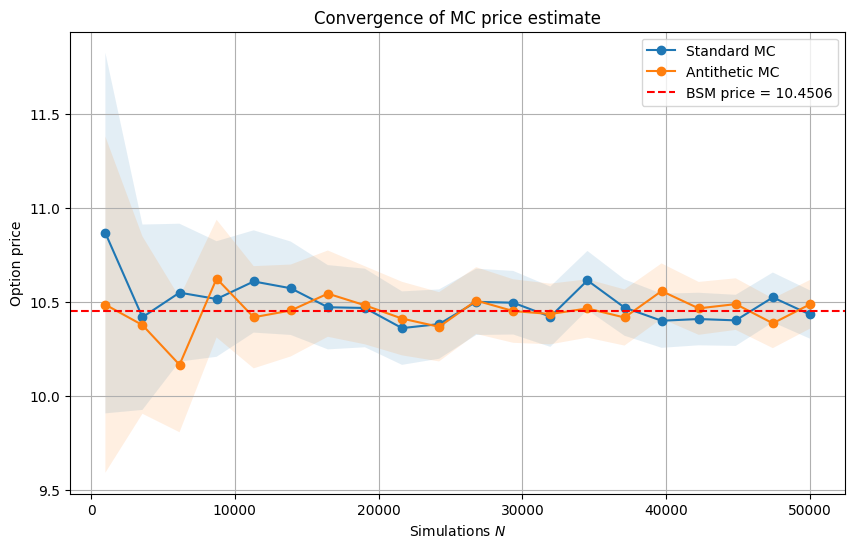

In [7]:
N_grid = np.linspace(1_000, 50_000, 20, dtype=int)

price_std, ci_low_std, ci_high_std = [], [], []
price_anti, ci_low_anti, ci_high_anti = [], [], []

for N in N_grid:
    p_std, ci_std, _ = mc_price(100, 100, 0.05, 1, 0.20, N)
    p_anti, ci_anti, _ = mc_price(100, 100, 0.05, 1, 0.20, N, antithetic=True)

    price_std.append(p_std)
    ci_low_std.append(ci_std[0])
    ci_high_std.append(ci_std[1])
    price_anti.append(p_anti)
    ci_low_anti.append(ci_anti[0])
    ci_high_anti.append(ci_anti[1])

plt.figure(figsize=(10, 6))
plt.plot(N_grid, price_std, "o-", label="Standard MC")
plt.fill_between(N_grid, ci_low_std, ci_high_std, alpha=0.12)

plt.plot(N_grid, price_anti, "o-", label="Antithetic MC")
plt.fill_between(N_grid, ci_low_anti, ci_high_anti, alpha=0.12)

plt.axhline(bsm, color="red", ls="--", label=f"BSM price = {bsm:.4f}")
plt.xlabel("Simulations $N$")
plt.ylabel("Option price")
plt.title("Convergence of MC price estimate")
plt.grid(True)
plt.legend()
plt.show()

The antithetic curve sits consistently below the standard MC curve, confirming variance reduction.  

### Key take-aways
* Antithetic pairing reduced variance by **the printed factor** in this at-the-money example.  
* Achieves the **same accuracy with fewer paths** or, equivalently, tighter confidence bands for a fixed budget.  
* Most effective when the payoff is monotone in the underlying (European, Asian, etc.).  
* Next up: **Control Variates**, often an order of magnitude stronger than antithetic variates.